In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as st
import numpy as np
import sklearn as sk
import datetime
import scipy.stats as st
import pickle
from math import radians, sin, cos, pi, asin, atan2
import datetime
import copy
% matplotlib inline

Attempt to load data from file. If it can't, download them. This is for the year-to-date files for 2017.

In [3]:
try: 

    df_meters = pd.read_csv('parking_meters_sd.csv', delimiter= '\t')
    df_trans = pd.read_csv('meter_transactions_2017.csv', delimiter= '\t')
    meter_dict = pd.read_csv('parking_meters_sd_dict.csv', delimiter= '\t')
    trans_dict = pd.read_csv('meter_transactions_2017_dict.csv', delimiter= '\t')
    print('Loaded dataframes from file')
    
except:
    urls = ['http://seshat.datasd.org/parking_meters/treas_parking_meters_loc_datasd.csv', 'http://seshat.datasd.org/parking_meters/meters_locations_dictionary_datasd.csv', 
            'http://seshat.datasd.org/parking_meters/treas_parking_payments_2017_datasd.csv', 'http://seshat.datasd.org/parking_meters/meters_transactions_dictionary_datasd.csv']
    
    df_titles = ['parking_meters_sd', 'parking_meters_sd_dict', 'meter_transactions_2017', 'meter_transactions_2017_dict']
    for i in range(len(urls)):
        df = pd.read_csv(urls[i])
        fname = df_titles[i] + '.csv'
        print('Loading ' + fname + ' dataframe from url. Saving to csv...')
        df.to_csv(fname, sep = '\t', index=False)
        
        print('Saving...')
    df_meters = pd.read_csv('parking_meters_sd.csv', delimiter= '\t')
    df_trans = pd.read_csv('meter_transactions_2017.csv', delimiter= '\t')
    meter_dict = pd.read_csv('parking_meters_sd_dict.csv', delimiter= '\t')
    trans_dict = pd.read_csv('meter_transactions_2017_dict.csv', delimiter= '\t')
    print('Done')

Loaded dataframes from file


Convert the two datetime columns to proper datetimes.

In [4]:
df_trans['trans_start'] = pd.to_datetime(df_trans['trans_start'])
df_trans['meter_expire'] = pd.to_datetime(df_trans['meter_expire'])

Picked July 2017 to examine for this exercise

In [6]:
df = df_trans[df_trans['trans_start'].dt.month == 7]

Ignore rows outside paid parking window, as per instructions. Note that removing rows per the hint still leaves some, so I'll get rid of rows where payments past 6pm are made. I'll leave in ones earlier, to account for payments that willcross into the valid time range

In [ ]:
df = df[(df['trans_start'] != df['meter_expire'])]
df = df[df['trans_start'].dt.hour<18]

### Part 1: 
Generate file with pole_id, sub-area, year, month, day, time, fraction of time paid per 5 minute interval, transactions iniatiated, and transactions ended.

Some data concerns:

1. Because there can be overlap between payments (from refeeding and others), this is going to cause some situations with % usage. Percentages greater than 1 will be found, unless dealt with specifically. I won't do this at this time. With more time, I could set up a tracker to keep track of continuos payments. A simple approximation would be to set payments greater than to 1, since the primary question is percentage of time occupied, which will always be included if no refunds are permitted.
    
2. Working assumption that all of these transactions are valid and were not retracted for some reason (in response to point above). I did see cases of repeat transactions that did not change the meter expiration that could be due to meter limits.

Relevant columns requested are are sub_area and pole

In [8]:
df_meters_sub = df_meters[['sub_area','pole']]

Per request, extract year, month, and day for each row. Primarily for reporting purposes - for predictions, I recommend sin/cos time deconstruction. Will be revisited.

In [9]:
df['year'] = df['trans_start'].dt.year
df['month'] = df['trans_start'].dt.month
df['day'] = df['trans_start'].dt.day

So here's where I may have overcomplicated some things. It's easy to separate out time intervals based on the pd.TimeGrouper function, but I need to keep track of portions of time that were covered by transactions, even if no transactions were initiated in a given time frame. Therefore, to perform this, I assemble pole_dict, in which each key is a pole_id, and then for each pole, I insert an empty dictionary with keys for each 5-minute time interval.

In [95]:
def generate_day_time_range(start, end, tdelta, lst = False):
    if lst:
        times = []
    else:
        times = {}
    delta = datetime.timedelta(0,0,0,0,tdelta)
    time = start
    while time < end:
        if lst:
            times.append(time)
        else:
            times[time] = 0 # Change to [] if using unique range
        time = time + delta
    return times

def generate_month_time_range(start, end, lst=False):
    if lst:
        times = []
    else:
        times = {}
    time = start
    
    day_span = datetime.timedelta(1)
    hour_span = datetime.timedelta(0,1,0,0,0,12)
    while time < end:
        
        hours = generate_day_time_range(time, time+hour_span, 5, lst=lst)
        if lst:
            times.extend(hours)
        else:
            times.update(hours)
        time = time + day_span
    return times

#month_dict = generate_month_time_range(datetime.datetime(2017,7,1,6), datetime.datetime(2017,8,1,6))

pole_dict = {}
percent_dict = {}
count = 0
for pole in df['pole_id'].unique():
    count+= 1
    span = generate_month_time_range(datetime.datetime(2017,7,1,6), datetime.datetime(2017,8,1,6))
    pole_dict[pole] = span
    percent_dict[pole] = span
    #sub_df = df[df['pole_id'] == pole]
    if count%1000 == 0:
        print(count)

1000
2000
3000
4000


Then, I iterate over each row in our dataframe, and then calculating the percentage of the indicated time interval paid for, and inserting it (adding the fraction to the previous value in cases where multiple transactions start or end in the same interval) into the pole_dict. There is absolutely a more elegant solution here, but I'm time constraints do not permit.

Again, this method leads to percent usages of over 100%.  

In [96]:
five_min = datetime.timedelta(0,0,0,0,5)
count =0
#for pole in df['pole_id'].unique():
for i, row in df.iterrows():
    pole = row['pole_id']
    
    start, end = row['trans_start'], row['meter_expire']
    s_rem = start.minute%5
    current_bin = start - datetime.timedelta(0,start.second,0,0,s_rem)
    time_from_bin = datetime.timedelta(0,start.second,0,0,start.minute%5)
    
    if end >= current_bin + five_min:
        pole_dict[pole][current_bin] += (five_min - time_from_bin).seconds/float(300) # The number of seconds paid for divided by number of seconds in 5 minutes
        #pole_dict[pole][current_bin].append((current_bin+time_from_bin,current_bin+five_min))
        #print(pole_dict[pole][current_bin])
    else:
        end_time_from_bin = datetime.timedelta(0,end.second,0,0,end.minute%5)
        pole_dict[pole][current_bin] += (end_time_from_bin - time_from_bin).seconds/float(300)

    while current_bin < end:
        current_bin = current_bin + five_min
        next_bin = current_bin + five_min
        if current_bin < end and current_bin.hour<18:
            if next_bin < end:
                pole_dict[pole][current_bin] += 1
                #pole_dict[pole][current_bin].append((current_bin,next_bin))
                #print(pole_dict[pole][current_bin])

            else:
                time_from_bin = datetime.timedelta(0,end.second,0,0,end.minute%5)
                pole_dict[pole][current_bin] += (time_from_bin).seconds/float(300)
                #pole_dict[pole][current_bin].append((current_bin,current_bin+time_from_bin))
                #print(pole_dict[pole][current_bin])
            

    count += 1
    if count%10000==0:
        print(count)
        

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000


In [98]:
# Now that I'm looking at 
c = 0
for i in pole_dict.keys():
    for j in pole_dict[i]:
        if pole_dict[i][j]<=1:
            c+=1
c

18798353

In [67]:
#df_test = df[['pole_id', 'trans_start', 'month', 'day']]
#df_test = df
#df_test.index = df['trans_start']
#df_test_resample = df_test.resample('5min', on='trans_start')

Getting a few values for the aggregate report. grouped_start to get counts and times of transactions started, grouped_end to get counts and times of expired time windows

In [99]:
df_start = df[['pole_id', 'trans_start']]
df_start.index = df_start['trans_start']
grouped_start = df_start.groupby(['pole_id',pd.TimeGrouper('5min')])

df_end = df[['pole_id', 'meter_expire']]
df_end.index = df_end['meter_expire']
grouped_end = df_end.groupby(['pole_id',pd.TimeGrouper('5min')])

This part takes the subset of data relevant to each pole, attaches the correct counts for start time and expiration time, then adds the percent usage from the pole_dict and inserts it into group_df, which will be used throughout the rest of this exercise. This is inelegant but it works for this amount of data. More time would lead to a better schema.

In [101]:
idx = generate_month_time_range(datetime.datetime(2017,7,1,6), datetime.datetime(2017,8,1,6), lst=True)

c=0
group_df = pd.DataFrame({})
limit = len(df['pole_id'].unique())-1

for pole in df['pole_id'].unique():
    
    sub = grouped_start.count().loc[pole].reindex(idx, fill_value=0)
    sub['meter_expire'] = grouped_end.count().loc[pole].reindex(idx, fill_value=0)['meter_expire']
    percents = []
    for i, row in sub.iterrows():
        if i in percent_dict[pole]:
            percents.append(percent_dict[pole][i])
            
    sub['usage'] = percents
    sub['pole_id'] = [pole]*len(sub)

    group_df = group_df.append(sub)
    c+=1
    if c%250 == 0 or c == limit:
        print(c)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4679


In [102]:
group_df = group_df.rename(columns={'trans_start': 'trans_start_count', 'meter_expire': 'expired_count', 'usage': 'Paid Occupied Percentage'})

In [103]:
# Save dataframe to avoid running through these again. Unfortunately, formatting changes will be different if reloading
# or assembling through this notebook
#group_df.to_csv('parking_meters_summary_SD_July2017_temp.csv', sep = '\t')

In [8]:
# If loading from file, use this
#group_df = pd.read_csv('parking_meters_SD_July2017_temp.csv', delimiter= '\t')
#group_df['trans_start'] = pd.to_datetime(group_df['trans_start'])

In [104]:
# If just continuing on, use this.
group_df = group_df.reset_index()

Extract year, month, day, and merge with df_meters_sub dataframe which has the requested location info

In [105]:
group_df['year'] = group_df['trans_start'].dt.year
group_df['month'] = group_df['trans_start'].dt.month
group_df['day'] = group_df['trans_start'].dt.day
group_df = group_df.merge(df_meters_sub, left_on='pole_id', right_on='pole')

Drop now redundant pole column.
Get daily time column, per request.
Drop the full datetime

In [106]:
group_df.drop(['pole'], axis = 1, inplace = True)
group_df['time'] = group_df['trans_start'].dt.time
group_df.drop(['trans_start'],axis=1,inplace=True)

Rearrange columns to something more logical. Could also turn to multiline to remove redundancies with pole_id and sub_area, but I'll just leave those as is.

In [107]:
group_df = group_df[['pole_id', 'sub_area', 'year', 'month', 'day', 'time', 'Paid Occupied Percentage', 'trans_start_count', 'expired_count']]

Finalize csv file. Remember caveats: Each row is explicit, non-grouped. Percent usage has small bug at close times. Not hard to fix, but takes time to run again. And of course, percentage assumption is not used, i.e. percent usage can be over 100% (>1.0) due to the fact that multiple transactions will keep the meter as being used. By setting all fractions greateer than 1 to 1 would get more 'realistic' details, but they would not necessarily be more accurate of user behavior, since users can leave earlier.

In [191]:
df_test = group_df.set_index(['pole_id', 'time'])

In [193]:
df_test.to_csv('parking_meters_summary_SD_July2017_test.csv', sep = '\t')

In [109]:
group_df.to_csv('parking_meters_summary_SD_July2017.csv', sep = '\t')

In [19]:
#group_df['time'] = group_df['trans_start'].dt.time

Some quick analyses - want to look at distributions by time interval and by day. Minutes past midnight is a decent way

In [111]:
group_df['min_past_midnight'] = group_df.time.apply(lambda x: x.hour*60+x.minute)

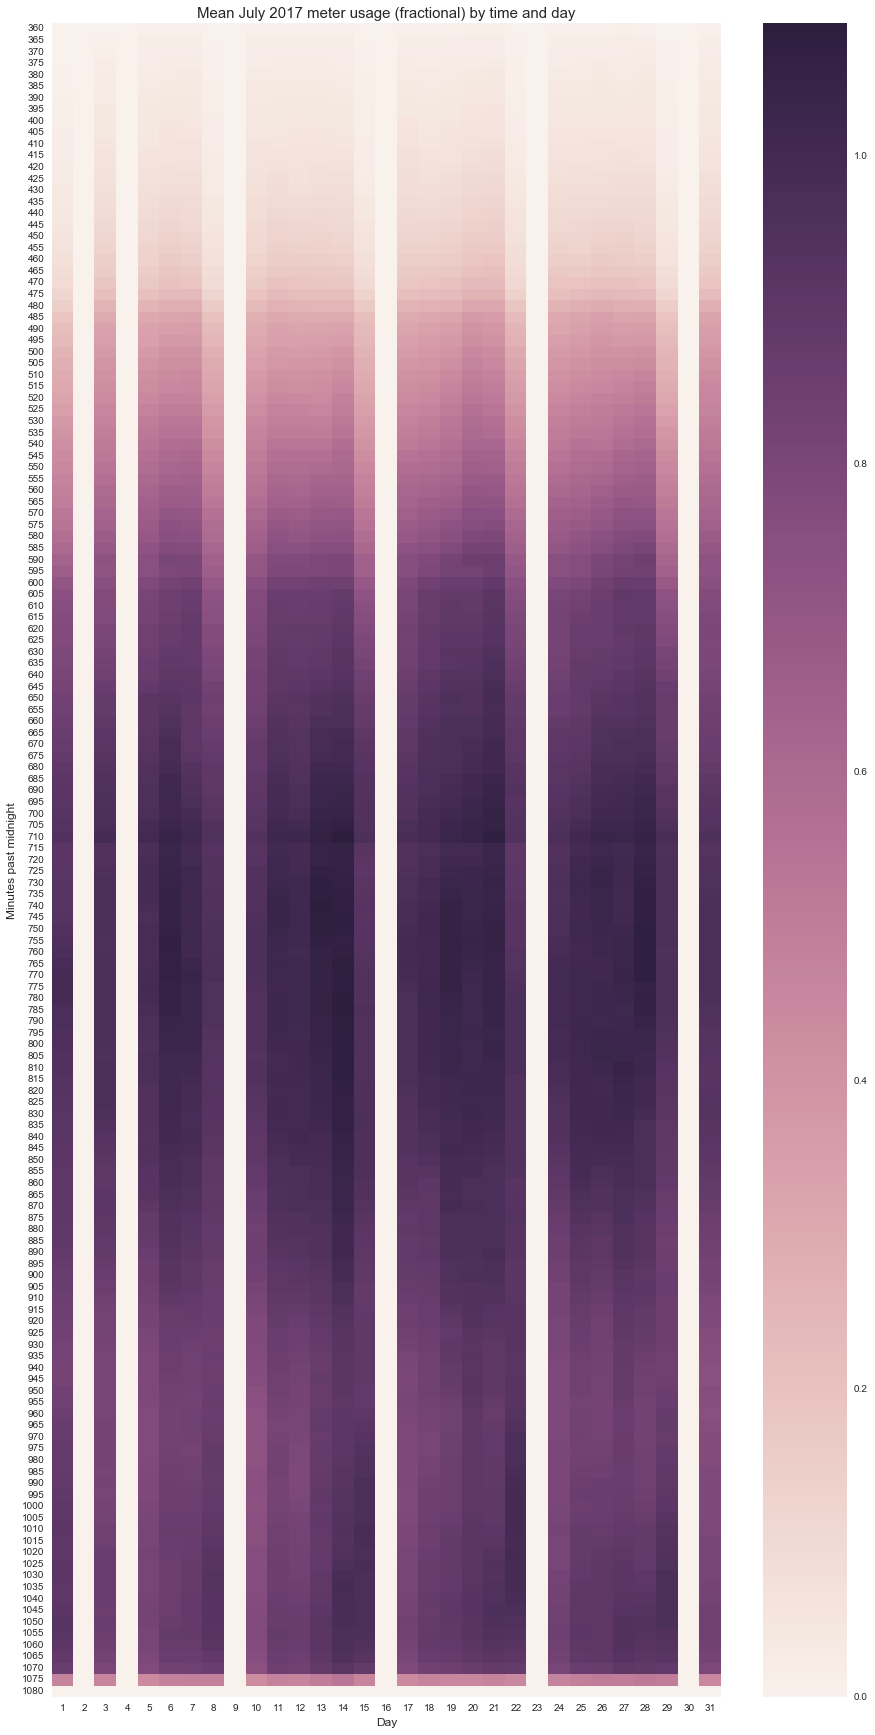

In [176]:
fig = plt.figure(figsize=(15,30))
ax = fig.add_subplot(1,1,1)
sns.heatmap(pd.pivot_table(group_df, index='min_past_midnight', columns='day', values='Paid Occupied Percentage', aggfunc=np.mean))
ax.set_title('Mean July 2017 meter usage (fractional) by time and day', size=15)
ax.set_ylabel('Minutes past midnight',size=12)
ax.set_xlabel('Day',size=12)

So this heat map has a few interesting features. First, if it wasn't known before, we can that see that meters are only active 6 days out of the week. That doesn't mean that some people won't accidentally pay during those days. July 2nd was also the Friday of the Fourth of July weekend, so it looks like meters were excused for that Friday, though interestingly not the Saturday.

On a day-to-day basis, we can see that Thursdays and Fridays have higher average time paid for, especially around midday. From a glance, it looks like Friday, July 14th had the most times paid for. If I had to guess (without much grasp of the geography), I'd say this was due to the Pride Parade the next day, possibly emphasized by people coming in from suburbs/further away who are less familiar with the meter systems.

In [113]:
group_df['Paid Occupied Percentage (adjusted)'] = group_df['Paid Occupied Percentage'].apply(lambda x: x if x<=1.0 else 1.0)

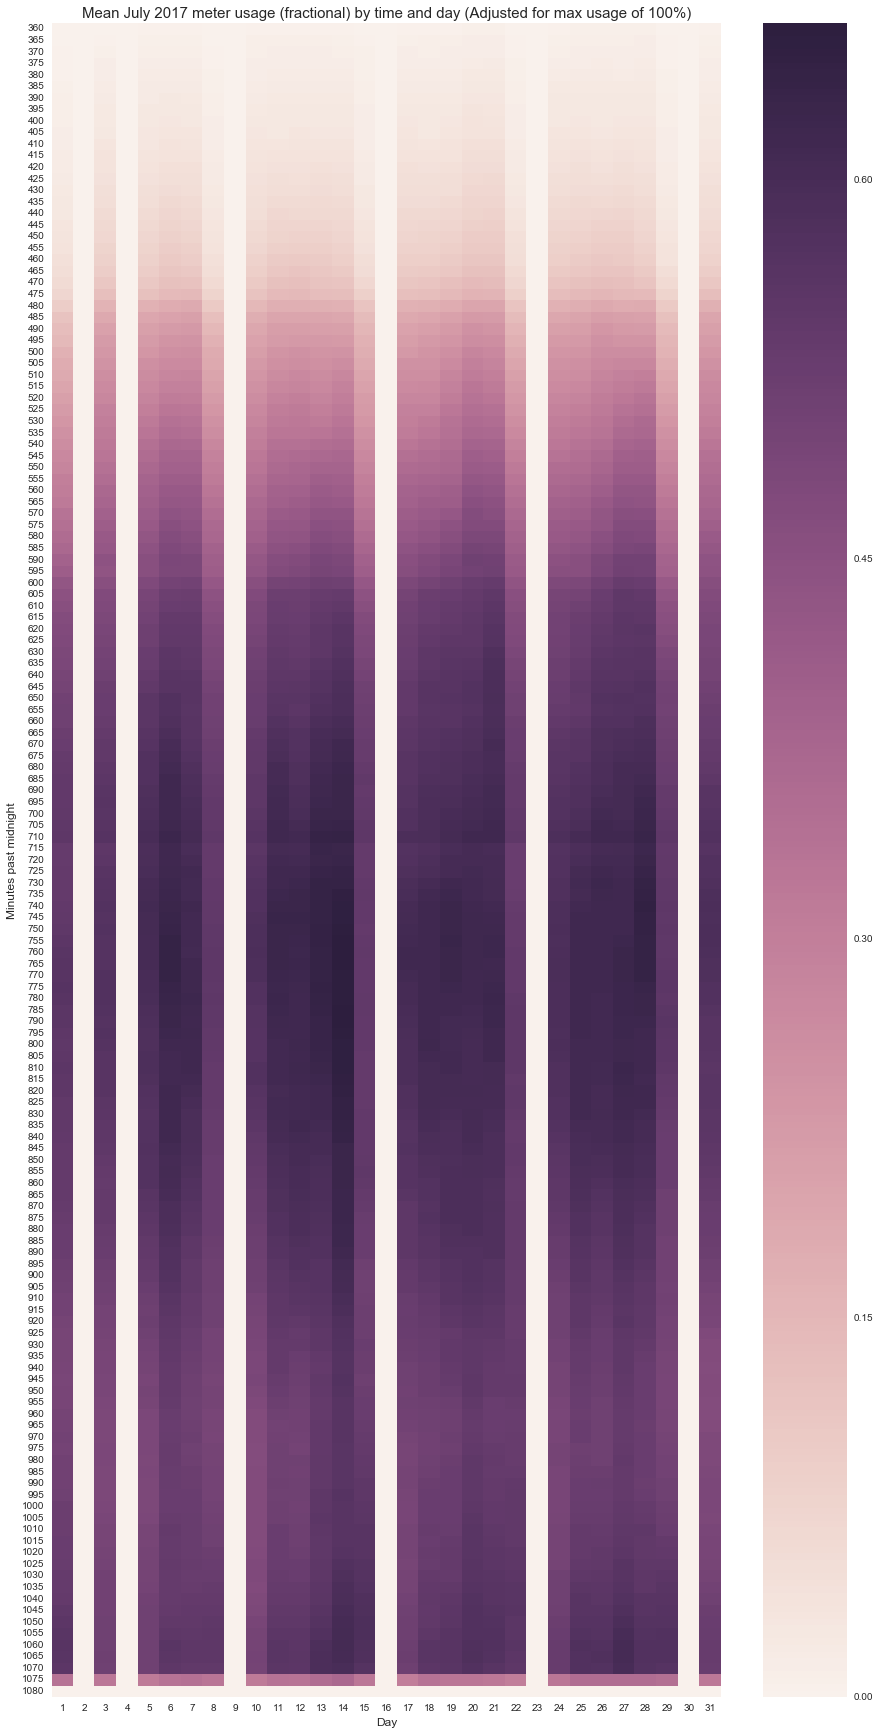

In [178]:
fig = plt.figure(figsize=(15,30))
ax = fig.add_subplot(1,1,1)
sns.heatmap(pd.pivot_table(group_df, index='min_past_midnight', columns='day', values='Paid Occupied Percentage (adjusted)', aggfunc=np.mean))
ax.set_title('Mean July 2017 meter usage (fractional) by time and day (Adjusted for max usage of 100%)', size=15)
ax.set_ylabel('Minutes past midnight',size=12)
ax.set_xlabel('Day',size=12)

When we approximate any interval-based percent usage as equal to 1 if it's greater than 1, then we get a slightly different heatmap. The scale for the mean is greatly reduced and changes are slightly fuzzier

In [144]:
df['duration'] = (df['meter_expire'] - df['trans_start'])
df['duration'] = df['duration'].dt.seconds/float(60)

(0, 200)

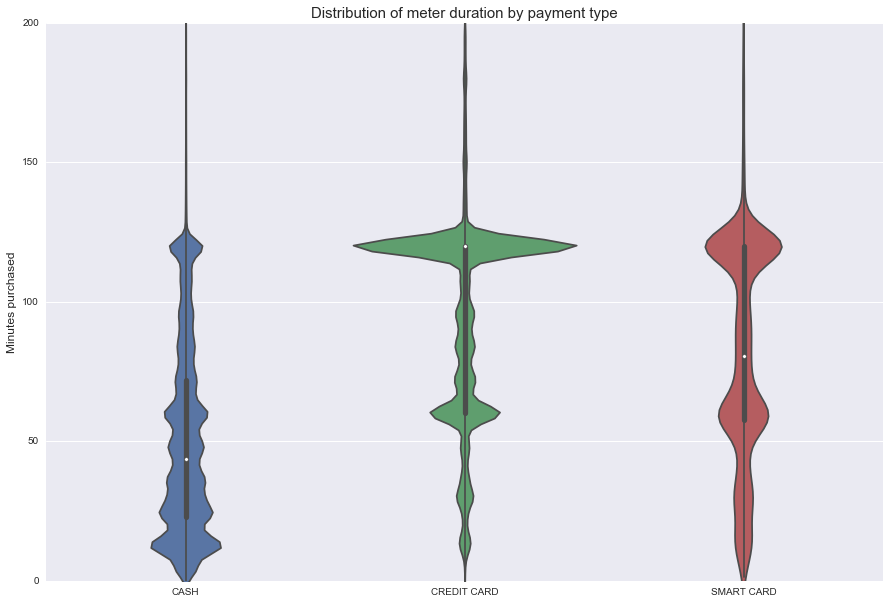

In [169]:
pay_methods = df['pay_method'].unique()
df_low = df[df['duration']<200]
fig, ax = plt.subplots(1,1, figsize = (15,10))
vplot = sns.violinplot(data=[df_low[df_low['pay_method'] == pay_methods[0]]['duration'],df_low[df_low['pay_method'] == pay_methods[1]]['duration'], df_low[df_low['pay_method'] == pay_methods[2]]['duration']])
vplot.set(xticklabels=pay_methods)
ax.set_title('Distribution of meter duration by payment type', size=15)
ax.set_ylabel('Minutes purchased',size=12)
ax.set_ylim([0,200])

We can also note the varying behaviors depending on payment type. Cash payments indicate more of a spread across a two hour window, whereas credit card payments are clustered around 1 and 2 hours.  Much more people tend to use credit card to purchase two hours of time, at a time.

We can also look on the level of the meter, but good visualizations for 4500+ meters is not ideal. But here's an example with 10 meters. Here we can see that certain meters have similar behavior, such as WF-800N and WG-300S. This could even be broken down by time and day, but we may be getting too sparse at that point. Significance testing would be best done at this point. A Bonferroni correction factor would be needed at this point, in order to counteract the tendency for faux-significance when making many comparisons.

(0, 200)

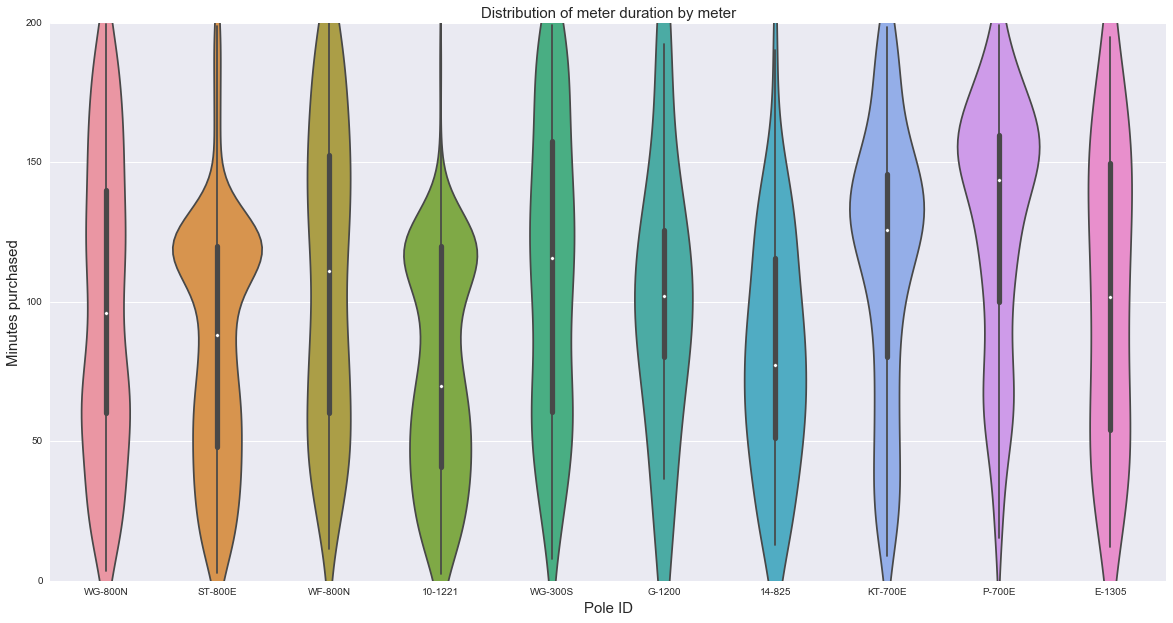

In [175]:
meters = df['pole_id'].unique()
fig, ax = plt.subplots(1,1, figsize = (20,10))
data_list = [df_low[df_low['pole_id'] == meters[x]]['duration'] for x in range(10)]
vplot = sns.violinplot(data=data_list)
vplot.set(xticklabels=meters[0:10])
ax.set_title('Distribution of meter duration by meter', size=15)
ax.set_ylabel('Minutes purchased',size=15)
ax.set_xlabel('Pole ID',size=15)
ax.set_ylim([0,200])